In this worksheet we show how to connect to a BaseX database containing XML documents representing source code. Data from individual models are stored in databases by the same names. The name of the database is the same as the name of the model. The name of the database to open is given in the model variable below:

In [ ]:
model = 'ApplicationFoundation'

In [ ]:
from BaseXClient import BaseXClient

# create session
session = BaseXClient.Session("localhost", 1984, "admin", "admin")

try:
    # create query instance
    input = """let $results := 
<Results>
{
  for $c in /Class | /Table
  
    let $allMethods := count($c/Method)
    let $privateMethods := count($c/Method[@IsPrivate = 'true'])
    let $protectedMethods := count($c/Method[@IsProtected = 'true']) (: Explicitly marked with protected keyword :)
    let $publicMethods := count($c/Method[@IsPublic = 'true'])
    let $internalMethods := count($c[@IsInternal = 'true'])
          
    (: Compensate for methods that lack a visibility keyword: They are protected. :)
    let $protectedMethods := $protectedMethods + ($allMethods - $privateMethods - $protectedMethods - $publicMethods - $internalMethods)  
      
    return <Result Class='{$c/@Name}' PrivateMethodCount='{$privateMethods}' ProtectedMethodCount='{$protectedMethods}' PublicMethodCount='{$publicMethods}' InternalMethodCount='{$internalMethods}'/>
}
</Results>
return <Totals 
  PrivateMethodCount='{sum($results/Result/@PrivateMethodCount)}'
  ProtectedMethodCount='{sum($results/Result/@ProtectedMethodCount)}'
  PublicMethodCount='{sum($results/Result/@PublicMethodCount)}'
  InternalMethodCount='{sum($results/Result/@InternalMethodCount)}' />"""

    session.execute("open " + model);
    query = session.query(input)

    # There is only one result, an XML tag called Totals with the
    # attributes provided.
    res = query.execute()
    print(res)
    
    # close query object
    query.close()

finally:
    # close session
    if session:
        session.close()

As you can see, the result of running the query in the BaseX database is stored in the res variable. For this demonstration, we will take these results and show then graphically using the mathplotlib library.

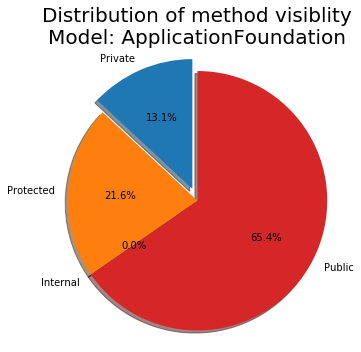

In [ ]:
import matplotlib.pyplot as plt

# Get the information from the XML using the lightweight Python XML library
import xml.etree.ElementTree as ET

tree = ET.fromstring(res)
privateCount = tree.get("PrivateMethodCount")
protectedCount = tree.get("ProtectedMethodCount")
publicCount = tree.get("PublicMethodCount")
internalCount = tree.get("InternalMethodCount")

fig = plt.figure(figsize=(5,5)) # In inches(!)
piechart = fig.add_subplot(111)

piechart.pie([privateCount, protectedCount, internalCount, publicCount], labels=("Private", "Protected", "Internal", "Public"),
        shadow=True, startangle=90, explode=(0.1, 0,0,0), autopct='%1.1f%%')
piechart.set_title ("Distribution of method visiblity\nModel: " + model, fontsize=20)
piechart.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()